In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Utils.masking import MaskGenerator, visualise_mask

import matplotlib.pyplot as plt

In [53]:
from Examples.ModelNet10.dataset import ModelNet10
from torchvision.transforms import RandomCrop
dataset = ModelNet10(root='../Datasets/', split='train', n=1)

Building dataset...


100%|██████████| 10/10 [00:00<00:00, 18.83it/s]


In [10]:
import math

def interpolate_pos_encoding(x, pos_embed):
    npatch = x.shape[1] 
    N = pos_embed.shape[1]
    if npatch == N:
        return pos_embed
    dim = x.shape[-1]
    pos_embed = nn.functional.interpolate(
        pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
        scale_factor=math.sqrt(npatch / N),
        mode='bicubic',
    )
    pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
    return pos_embed
    
x = torch.randn(1, 16, 256)
p = torch.randn(1, 25, 256)
p = interpolate_pos_encoding(x, p)
p.shape

torch.Size([1, 16, 256])

In [57]:
def apply_masks(x, masks):
    """
    :param x: tensor of shape [B (batch-size), N (num-patches), D (feature-dim)]
    :param masks: list of tensors containing indices of patches in [N] to keep
    """
    all_x = []
    for m in masks:
        mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1))
        all_x += [torch.gather(x, dim=1, index=mask_keep)]
    return torch.cat(all_x, dim=0)


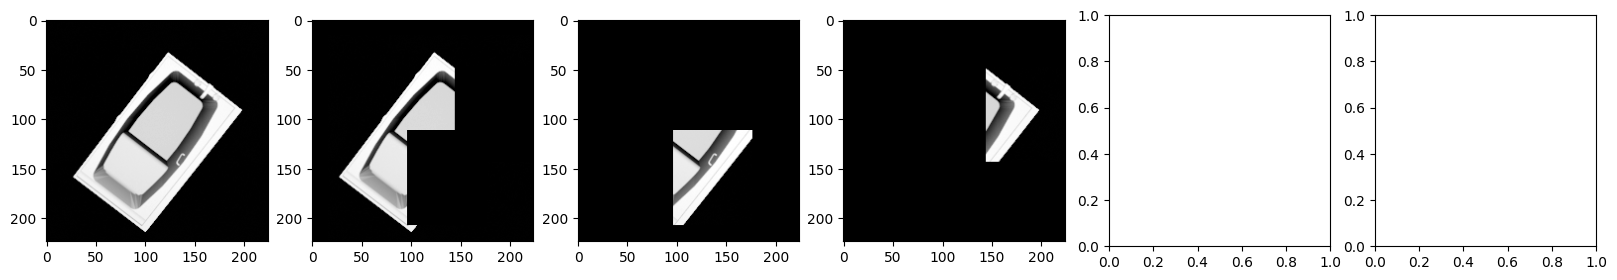

In [81]:
mask_generator = MaskGenerator(npred=2)
enc_masks, pred_masks = mask_generator.sample_masks(1)
# img = torch.ones(1, 224, 224)
img = dataset.data[0][0]
enc_mask = visualise_mask(img, enc_masks[0], (14, 14))
pred_mask0 = visualise_mask(img, pred_masks[0], (14, 14))
pred_mask1 = visualise_mask(img, pred_masks[1], (14, 14))
# pred_mask2 = visualise_mask(img, pred_masks[2], (14, 14))
# pred_mask3 = visualise_mask(img, pred_masks[3], (14, 14))

fig, axs = plt.subplots(1, 6, figsize=(20, 3))
axs[0].imshow(img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axs[1].imshow(enc_mask.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axs[2].imshow(pred_mask0.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axs[3].imshow(pred_mask1.permute(1, 2, 0).cpu().numpy(), cmap='gray')
# axs[4].imshow(pred_mask2.permute(1, 2, 0).cpu().numpy(), cmap='gray')
# axs[5].imshow(pred_mask3.permute(1, 2, 0).cpu().numpy(), cmap='gray')


In [3]:
from Utils.functional import repeat_interleave_batch

x = torch.randn(3, 2, 1)
x = repeat_interleave_batch(x, 3, 2)
x.shape
x

tensor([[[-0.6009],
         [-0.1224]],

        [[-0.8199],
         [ 1.7122]],

        [[-2.3364],
         [ 0.7717]],

        [[-0.6009],
         [-0.1224]],

        [[-0.8199],
         [ 1.7122]],

        [[-2.3364],
         [ 0.7717]]])

In [9]:
# enc_masks: list of 

(torch.Size([1, 64]), torch.Size([1, 64]))

Loaded pre-built dataset.
Loaded pre-built labels


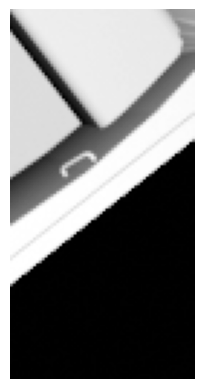

In [128]:

img = dataset.data[0][0]
transform = RandomCrop((64, 128))
img = transform(img)
import matplotlib.pyplot as plt



plt.imshow(img.permute(2, 1, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()


In [3]:
import torch
x1 = torch.randn(2, 4)
x2 = x1.clone()

x1 = x1.flip(0)
x1 = x1.flip(1)
x2 = x2.flip(1)

torch.allclose(x1, x2)

False

In [ ]:
x = torch.randn(10, 100)
y = torch.randn(2, 54)
z = torch.randn(1, 20)

torch.save({'x': x, 'y': y, 'z': z}, 'tensors.pth')
x, y, z = None, None, None

loaded_tensors = torch.load('tensors.pth')
x = loaded_tensors['x']
y = loaded_tensors['y']
z = loaded_tensors['z']





In [108]:
    
z = torch.randn(1, 512)
model = Decoder224(512)
model(z).shape 

torch.Size([1, 1, 224, 224])

In [45]:
class mnist_cnn_decoder(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(num_features, 256, 3, 1),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 3, 3),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, 3, 3),
            nn.ReLU(),
            
            # nn.ConvTranspose2d(64, 32, 2, 1),
            # nn.ReLU(),
            # nn.Conv2d(32, 1, 3, 1, 1),
        )

    def forward(self, z):
        z = z.view(-1, self.num_features, 1, 1)
        return self.decoder(z)

model = mnist_cnn_decoder(512)
z = torch.randn(1, 512)
model(z).shape

torch.Size([1, 64, 27, 27])